Notebook to compare mean outgoing longwave radiation at toa from NextGEMS simulations (using Low Resolution Archive) with ERA5 eanalysis data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from aqua import Reader, catalogue
catalogue();

IFS	tco3999-ng5	2.8km experiment, coupled with FESOM
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- interpolated_global	NN interpolation to 5400x2700 grid (lon=[-180,180], lat=[-90, 90])
IFS	tco2559-ng5	4km experiment, coupled with FESOM
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- interpolated_global	NN interpolation to 5400x2700 grid (lon=[-180,180], lat=[-90, 90])
	- lra-r100-mon	LRA monthly data 1x1 deg regular grid
IFS	tco1279-orca025	9km baseline, coupled to NEMO, deep conv ON
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- lra-r100-mon	LRA monthly data 1x1 deg regular grid
IFS	test-tco2559	4km experiment, coupled with FESOM
	- ICMGG_atm2d	2d output
	- ICMU_atm3d	3d output
IFS	test-tco79	TCO79 test data
	- short	original 2d output
	- long	coarse IFS data 1y

FESOM	tco3999-ng5	2.5km experiment,

Text(0.5, 1.0, 'global mean top net thermal radiation flux')

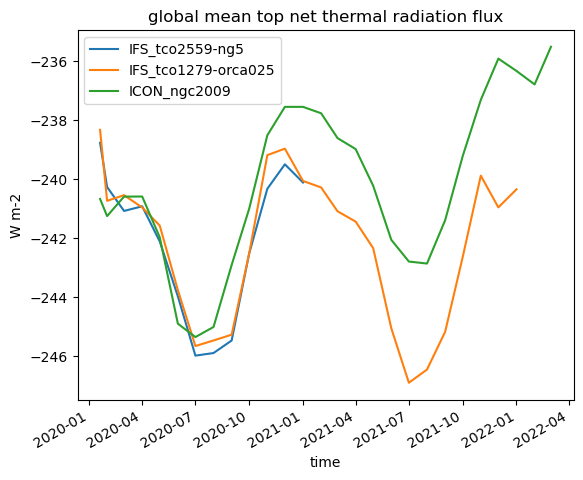

In [17]:
model_list = ["IFS", "ICON"]
exp_name = {"IFS": ["tco2559-ng5","tco1279-orca025"], "ICON": ["ngc2009"]}
source = {"IFS": ["lra-r100-mon"], "ICON": ["lra-r100-mon"]}
#grids = {"IFS": ["r100"], "ICON": ["r100"], "CERES": None}

data = {}
for model in model_list:
    for exp in exp_name[model]:
        for src in source[model]:
            reader = Reader(model=model, exp=exp, source=src, regrid="r100")
            data[(model, exp)] = reader.retrieve(fix=False)["mtntrf"]

plt.figure()
for model in model_list:
    for exp in exp_name[model]:
        reader.fldmean(data[(model, exp)]).plot(label=f"{model}_{exp}")
plt.legend()
plt.ylabel("W m-2")
plt.title("global mean top net thermal radiation flux")

In [16]:
#CERES	ebaf-toa41	CERES-EBAF
model_list = ["IFS", "ICON", "CERES"]
exp_name = {"IFS": ["tco2559-ng5","tco1279-orca025"], "ICON": ["ngc2009"], "CERES": ["ebaf-toa41"]}
source = {"IFS": ["lra-r100-mon"], "ICON": ["lra-r100-mon"], "CERES": ["monthly"]}
#grids = {"IFS": ["r100"], "ICON": ["r100"], "CERES": None}

data = {}
for model in model_list:
    for exp in exp_name[model]:
        for src in source[model]:
            if model=="CERES":
                reader = Reader(model=model, exp=exp, source=src)
                data[(model, exp)] = reader.retrieve(fix=False)["mtntrf"]
            else:
                reader = Reader(model=model, exp=exp, source=src, regrid="r100")
                data[(model, exp)] = reader.retrieve(fix=False)["mtntrf"]

plt.figure()
for model in model_list:
    for exp in exp_name[model]:
        reader.fldmean(data[(model, exp)]).plot(label=f"{model}_{exp}")
plt.legend()
plt.ylabel("W m-2")
plt.title("global mean top net thermal radiation flux")

FileNotFoundError: [Errno 2] No such file or directory: '/pool/data/ICDC/atmosphere/ceres_ebaf/DATA/CERES_EBAF-TOA_Ed4.1_Subset_200003-202203.nc'

In [9]:
Reader(model="CERES", exp="ebaf-toa41", source="monthly")